In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [23]:
df=pd.read_csv("sentiment.csv")
df.head()

,Phrase,label
0,Spider-man is better than any summer blockbust...,Positive
1,of good sense,Positive
2,", then knock yourself out and enjoy the big sc...",Negative
3,So could young romantics out on a date .,Positive
4,humour,Positive


In [24]:
len(df)

2800

## Data Analysis and visualization

### count of number of Phrases according to Label types

In [71]:
from collections import Counter

In [72]:

labels_count=Counter(df['label']) 
print(labels_count)

Counter({'Positive': 1800, 'Negative': 1000})


Text(0.5, 1.0, 'Number of phrase of each label types')

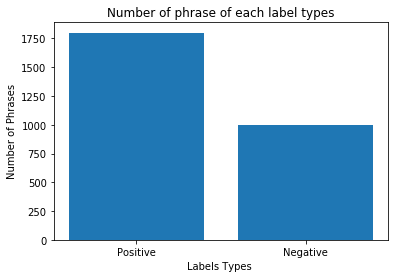

In [73]:
plt.bar(range(len(labels_count)),list(labels_count.values()),tick_label=list(labels_count.keys()))
plt.xlabel("Labels Types ")
plt.ylabel("Number of Phrases")
plt.title("Number of phrase of each label types")

# Split into train,val and test set


In [27]:
total_len=len(df)
train_len=int(0.6*total_len)
val_len=int(0.2*total_len)
print(train_len,val_len)


1680 560


In [28]:
train_df=df[0:train_len]
val_df=df[train_len:train_len+val_len]
test_df=df[train_len+val_len:]

In [29]:

vocab=list() 
for i in train_df.Phrase.tolist():
    vocab.extend(i.split(" ")) 
u_vocab=list(set(vocab))#set gives only unique values  
print(len(vocab), len(u_vocab))
    

13855 1844


# Feature extraction

In [30]:
train_df.head()

,Phrase,label
0,Spider-man is better than any summer blockbust...,Positive
1,of good sense,Positive
2,", then knock yourself out and enjoy the big sc...",Negative
3,So could young romantics out on a date .,Positive
4,humour,Positive


In [31]:
def extract_feature(f_df):
    feature = []
    label = []
    for index, row in train_df.iterrows():
        words = row['Phrase'].split(" ")
        f = []
        for v in u_vocab:
            if v in words:
                f.append(1)
            else:
                f.append(0)
        if row['label'] == "Positive":
            label.append(1)
        elif row['label'] == "Negative":
            label.append(0)

        feature.append(f)
    feature = np.array(feature)
    label = np.array(label)
    label = label.reshape(-1,1)
    return feature, label

In [32]:
x_train, y_train=extract_feature(train_df)
x_val,y_val=extract_feature(val_df)
x_test,y_test=extract_feature(test_df)


In [33]:
x_train=np.insert(x_train,0,values=1,axis=1)
x_val=np.insert(x_val,0,values=1,axis=1)
x_test=np.insert(x_test,0,values=1,axis=1)

In [34]:
print(x_test.shape)
print(x_train.shape)

(1680, 1845)
(1680, 1845)


## Build Model

In [35]:
#Binary cross Entropy loss
def CEL(h,y):
    return (-y*np.log(h)-(1-y)*np.log(1-h)).mean()



In [44]:
np.random.seed(42)


params = {
    'number_of_iterations': 1000,
    'learning_rate': 0.0001
}

grid_param = {
    'number_of_iterations': [1000, 2000],
    'learning_rate': [0.001,0.1]
}

In [45]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [46]:
    
def train_model(X_train,y_train, X_val, y_val, param):
    W=np.random.rand(X_train.shape[1]).reshape(-1,1)
    train_error=[]
    for i in range(1,param["number_of_iterations"]):
        h_train=sigmoid(np.matmul(X_train,W))
        train_loss=CEL(h_train,y_train)
        
        train_error.append(train_loss)
        
        gradient=(np.matmul(np.transpose(X_train),(h_train-y_train)))/X_train.shape[0]
        W-=params["learning_rate"]*gradient
        
    h_val=sigmoid(np.matmul(X_val,W))
    val_loss=CEL(h_val,y_val)        
    print(param,val_loss)
    return W,train_error

## Grid Search

In [47]:
#grid search parameter with val loss
import itertools
grid = list(itertools.product(grid_param['number_of_iterations'],grid_param['learning_rate']))
print(grid)

[(1000, 0.001), (1000, 0.1), (2000, 0.001), (2000, 0.1)]


In [51]:
for g in grid:
    p={
        'number_of_iterations':g[0],
        'learning_rate':g[1]
    }
    train_model(x_train,y_train,x_val,y_val,p)

{'number_of_iterations': 1000, 'learning_rate': 0.001} 1.8231977442458083
{'number_of_iterations': 1000, 'learning_rate': 0.1} 1.7441895766951088
{'number_of_iterations': 2000, 'learning_rate': 0.001} 1.7864027477089286
{'number_of_iterations': 2000, 'learning_rate': 0.1} 1.739627801250276


## Train Loss Plot for Best Model

In [57]:
params={
    'number_of_iterations':2000,
    'learning_rate':0.1
}
final_weights,train_loss=train_model(x_train,y_train,x_val,y_val,params)

{'number_of_iterations': 2000, 'learning_rate': 0.1} 0.4194143254576193


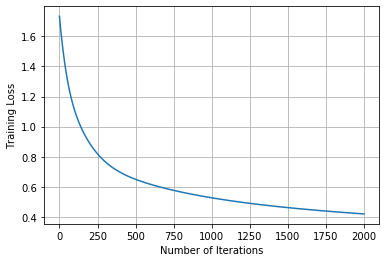

In [58]:

plt.plot(train_loss)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.grid()
plt.show()

## Model Evalution

In [59]:

def predict(X_test,final_weights,threshold):
    predictions=sigmoid(np.matmul(X_test,final_weights))
    final_predictions=[]
    for x in predictions:
        if x>=threshold:
            final_predictions.append(1)
        else:
            final_predictions.append(0)
    return final_predictions

In [61]:
predictions=predict(x_test,final_weights,0.5)

## confusion matrix 

In [62]:

def get_confusion_matrix(actual,predicted):
    confusion_matrix=np.zeros((2,2))
    for x,y in zip(actual,predicted):
        confusion_matrix[x,y] +=1
    return confusion_matrix

In [63]:

confusion_matrix=get_confusion_matrix(y_test,predictions)
print(confusion_matrix)

[[ 323.  271.]
 [  60. 1026.]]


## Accuracy 
(TP+TN)/(Tp+TN+FP+FN)

In [64]:
accuracy=(confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix)
print(accuracy)

0.8029761904761905


## Recall
TP/(TP+FN)

In [65]:

recall=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
recall

0.5437710437710438

## Precision
TP/(TP+FP) 


In [66]:
precision=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[1][0])
precision

0.8433420365535248

# F1-Score 

In [67]:

f1_score=(2*recall*precision)/(recall+precision)
f1_score

0.661207778915046

# ROC Curve

In [69]:
TPR=[]
FPR=[]
for threshold in np.arange(0,1,0.1):
    predictions=predict(x_test,final_weights,threshold)
    confusion_matrix=get_confusion_matrix(y_test,predictions)
    true_pos_rate=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
    false_pos_rate=(confusion_matrix[1][0])/(confusion_matrix[1][0]+confusion_matrix[1][1])
    TPR.append(true_pos_rate)
    FPR.append(false_pos_rate)

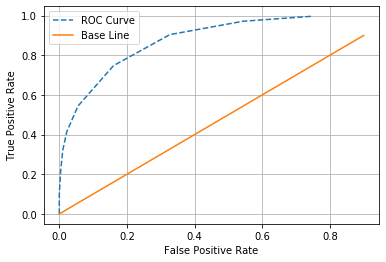

In [70]:
base=np.arange(0,1,0.1)
plt.plot(FPR,TPR,linestyle='--',label='ROC Curve')
plt.plot(base,base,label='Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
